### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


#### __problema continuo__

Sea el problema bidimencional pulso gausiano rotatorio definido por la ecuacion: 
$$
\frac{\partial T}{\partial t} - \alpha \nabla  T =Q \  \text{en} \  M=\Omega \times (0,t_f) 
$$

Donde $u(x,t) \in \mathbb{R}$ 
$$\Omega $$
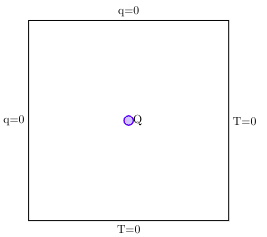

con: 

$$Q=10$$
$$\alpha =0.001$$
## Problema variacional

Encontrar un  $T \ \in \ V$  tal que 
$$
        \int \frac{\partial T}{\partial t}d\Omega +\int \alpha \nabla v \nabla T d\Omega  - \int_{\partial \Omega} \alpha q \cdot n ds - \int Qvd\Omega = 0
$$

## definicion funciones 

In [10]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
from matplotlib.legend_handler import HandlerLine2D
from label_lines import *
import math
import scipy
import time
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import pandas as pd
from mshr import *
import sys
import os
from pathlib import Path
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
parameters['linear_algebra_backend'] = 'Eigen'
start_code = time.time()
def fi (A,m,tau=1):
    d=scipy.sparse.identity(m)
    exp_A =scipy.linalg.expm(tau*A)
    return (exp_A-d)*spsl.spsolve(tau*A,d) , exp_A
# algoritmos de arnoldi
def arnoldi_iteration_m(A, b,tau,n):
    m = A.shape[0]
    h = np.zeros((n + 1, n))
    Q = np.zeros((m, n + 1))
    e_1=np.zeros(n)
    e_1[0]=1
    e_m=np.zeros(n)
    e_m[n-1]=1
    beta= np.linalg.norm(b)
    q = b / beta
    Q[:, 0] = q
    for k in range(n):
        v = A.dot(q)
        for j in range(k + 1):
            h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        q = v / h[k + 1, k]
        Q[:, k + 1] = q

    fi_m,exp_H =fi(h[0:n, 0:n],n,tau)
    error = beta*abs(h[n,n-1]*tau*e_m.dot(np.array(fi_m.dot(e_1))[0]))
    print(f"H dim= {Q[:,0:n].shape[1]} error = {error}")
          
    return Q[:,0:n], h[0:n, 0:n],fi_m,e_1,n,exp_H

def arnoldi_iteration(A, b,tau):
    m = A.shape[0]
    beta= np.linalg.norm(b)
    tol=1E-16
    n_int=4
    n=n_int
    error=1
    #print("beta on er",beta)
    eta=1/sqrt(2)
    H = np.zeros((n + 1, n))
    V = np.zeros((m, n + 1))
    V[:, 0] = b / beta
    j=0
    while error >= tol:
        if n>2 :
            H=np.pad(H, [(0, 1), (0, 1)], mode='constant', constant_values=0)
            V=np.pad(V, [(0, 0), (0, 1)], mode='constant', constant_values=0)
        e_m=np.zeros(n)
        e_m[n-1]=1
        e_1=np.zeros(n)
        e_1[0]=1
        v = A.dot(V[:, j])
        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i].conj(), v)  # <-- V needs conjugation!
            v = v - H[i, j] * V[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        V[:, j + 1] = v / H[j + 1, j]
        j += 1
        if n>n_int or (n==n_int and j==n_int):
            fi_m,exp_H =fi(H[0:n, 0:n],n,tau)
            error = beta*abs(H[n,n-1]*tau*e_m.dot(np.array(fi_m.dot(e_1))[0]))
            n += 1
    print(f"H dim= {V.shape[1]} error = {error}")
    return V[:,0:n-1], H[0:n-1, 0:n-1],fi_m,e_1,n,exp_H 
class left(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0],0) and on_boundary
class right(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0],1)
def on_boundary(x, on_boundary):
    return on_boundary
def exp_form_no(mesh):
    V=FunctionSpace(mesh,"CG",1)

    u_n=project(u_0,V)

    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    n=FacetNormal(mesh)

    bcs =0 #[DirichletBC(V, u_a,contorno,1)] #[DirichletBC(V,Constant(0),contorno,1)]
    # bc2 =DirichletBC(V,Constant(25),contorno,2)
    bcs =DirichletBC(V, u_a, on_boundary)    # bcs=[bc2]
    # ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
    K_fem =0.0001*dot(grad(u), grad(v))*dx +Dx(u, 0)*v*dx   # Formulación débil
    C_fem=u*v*dx
    ds = Measure('ds', domain=mesh, subdomain_data=contorno)
    Q_fem =v*f*dx #+v*q*ds(1)
    #ensamble matriz capacitiva 
    C=assemble(C_fem)
    
    #ensamble matriz de rigidez
    K=assemble(K_fem)
    #  #penalización

    if bcs != 0:
        if isinstance(bcs, list):
            [bc.apply(K) for bc in bcs]
            [bc.apply(C) for bc in bcs]#penalización
        else:
            bcs.apply(K)
            bcs.apply(C)
    #metodo sparse
    K_=scipy.sparse.csr_matrix(K.array()) 
    N_degree=C.array().shape[0]
    C_=scipy.sparse.csc_matrix(C.array())
    I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))
    C_1=scipy.sparse.linalg.spsolve(C_,I_n)
    #metodo coarse np
    A=-C_1.dot(K_)
    A=A.toarray()
    # print("K matrix" , K_.toarray())
    # print("C matrix" , C_.toarray())  
    return(V,u,v,A,C_1,Q_fem,u_n,bcs)

def Q_t_no(Q_fem,C_1,u_t,v_t,f,bcs):

    Q_v=assemble(Q_fem)
    if bcs != 0:
        if isinstance(bcs, list):
            [bc.apply(Q_v) for bc in bcs] #penalización
        else:
            bcs.apply(Q_v)
    Q_ = Q_v.get_local()
    Q_a =C_1.dot(Q_)
    return Q_a
def exp_solver_no(A,u_i,n,table,auto,m_u,u=0):
    arnoldi_ti=time.time()
    Beta=np.linalg.norm(u_i)
    if auto:
        V_m,H_m,fi_m,e_1,m,exp_H  = arnoldi_iteration(A,u_i,real_dt)
    else:
        V_m,H_m,fi_m,e_1,m,exp_H  = arnoldi_iteration_m(A,u_i,real_dt,m_u)
    arnoldi_t=time.time()-arnoldi_ti
    solver_ti=time.time()
    if n==0:
        u = real_dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)+u_n.vector().get_local()
    else:
        u += real_dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)
    solver_t=time.time() -solver_ti
    table.append([arnoldi_t,solver_t,V_m.shape[1]])
    return(u)

def exp_form(mesh):
    V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
 
    # Definición de la condición de frontera
    u_n = interpolate(u_0, V)  # Interpola u_D en el espacio de funciones V
    bcs=0
    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    K_fem =0.0001*dot(grad(u), grad(v))*dx +Dx(u, 0)*v*dx   # Formulación débil problema linealizado
    C_fem=u*v*dx
    C=assemble(C_fem)
    
    #ensamble matriz de rigidez
    K=assemble(K_fem)
    #  #penalización
    
    K_=scipy.sparse.csr_matrix(K.array()) 
    N_degree=C.array().shape[0]
    C_=scipy.sparse.csc_matrix(C.array())
    I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))
    C_1=scipy.sparse.linalg.spsolve(C_,I_n)
    #metodo coarse np
    A=-C_1.dot(K_)
    A=A.toarray()
    # print("K matrix" , K_.toarray())
    # print("C matrix" , C_.toarray()) 
    u_i=u_n
    return(V,A,u_i,bcs)
def exp_solver(A,u_i,table,auto,m_u=0):
    arnoldi_ti=time.time()
    
    Beta=np.linalg.norm(u_i.vector().get_local())
    if auto:
        V_m,H_m,fi_m,e_1,m,exp_H  = arnoldi_iteration(A,u_i.vector().get_local(),real_dt)
    else:
        V_m,H_m,fi_m,e_1,m,exp_H  = arnoldi_iteration_m(A,u_i.vector().get_local(),real_dt,m_u)

    arnoldi_t=time.time()-arnoldi_ti
    solver_ti=time.time()
    u_i.vector()[:]=Beta*np.dot(np.dot(V_m,exp_H),e_1.T)
    solver_t=time.time() -solver_ti
    table.append([arnoldi_t,solver_t,V_m.shape[1]])
    return(u_i)

def BDF_form_no(mesh,pconst):
    V=FunctionSpace(mesh,"P",1)

    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    n=FacetNormal(mesh)
    x = SpatialCoordinate(mesh)
    
    # Definición del valor inicial
    u_n = Function(V)
    u_n = interpolate(u_a, V)  # Interpola u_D en el espacio de funciones V
    u_nn = Function(V)
    u_nn = project(u_a, V) 
    u_nnn = Function(V)
    u_nnn = project(u_a, V) 


    du=pconst[0]*u
    du_n=pconst[1]*u_n
    du_nn=pconst[2]*u_nn
    du_nnn=pconst[3]*u_nnn
    du_t= du+du_n +du_nn +du_nnn


    bcs =0#[DirichletBC(V, u_a, on_boundary)]
    
    ds = Measure('ds', domain=mesh, subdomain_data=contorno)
    F = du_t*v*dx + real_dt*Dx(u, 0)*v*dx + 0.0001*real_dt*dot(grad(u), grad(v))*dx - real_dt*v*f*dx #- real_dt*v*q*ds(1)

    L, R = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación
    A1 = assemble(L)
    
    if bcs != 0:
        if isinstance(bcs, list):
            [bc.apply(A1) for bc in bcs]#penalización
        else:
            bcs.apply(A1)
    return(V,L,R,bcs,u_n,u_nn,u_nnn)
def BDF_form(mesh,pconst):
    V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
    V_vec = VectorFunctionSpace(mesh, 'CG',2)
    

    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    #BDF
    u_n = interpolate(u_0, V)  # Interpola u_D en el espacio de funciones V
    u_nn = interpolate(u_0, V) 
    u_nnn = interpolate(u_0, V) 
    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test

    

    du=pconst[0]*u
    du_n=pconst[1]*u_n
    du_nn=pconst[2]*u_nn
    du_nnn=pconst[3]*u_nnn
    du_t= du+du_n +du_nn +du_nnn
    F = du_t*v*dx + real_dt*Dx(u, 0)*v*dx + 0.0001*real_dt*dot(grad(u), grad(v))*dx - real_dt*v*f*dx  # Formulación débil
    L, R = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación
    return(V,L,R,u_n,u_nn,u_nnn)


### Problema Homogeneo

tipo de la matrix  <class 'dolfin.cpp.la.Matrix'>
[[ 0.50 -0.50  0.00 ...  0.00  0.00  0.00]
 [ 0.50  0.00 -0.50 ...  0.00  0.00  0.00]
 [ 0.00  0.50  0.00 ...  0.00  0.00  0.00]
 ...
 [ 0.00  0.00  0.00 ...  0.00 -0.50  0.00]
 [ 0.00  0.00  0.00 ...  0.50  0.00 -0.50]
 [ 0.00  0.00  0.00 ...  0.00  0.50 -0.50]]
step:1 of 10 time = 1.0


/home/sebastian/anaconda3/envs/fenics_base/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/home/sebastian/anaconda3/envs/fenics_base/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


H dim= 35 error = 0.0
step:2 of 10 time = 2.0
H dim= 41 error = 1.8771027449125178e-17
step:3 of 10 time = 3.0
H dim= 34 error = 0.0
step:4 of 10 time = 4.0
H dim= 46 error = 0.0
step:5 of 10 time = 5.0
H dim= 30 error = 0.0
step:6 of 10 time = 6.0
H dim= 45 error = 0.0
step:7 of 10 time = 7.0
H dim= 32 error = 0.0
step:8 of 10 time = 8.0
H dim= 44 error = 0.0
step:9 of 10 time = 9.0
H dim= 30 error = 0.0
step:10 of 10 time = 10.0
H dim= 44 error = 0.0


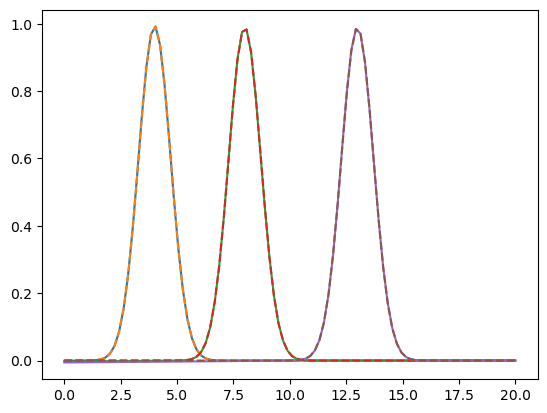

In [8]:
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
start_code = time.time()
dt = 1
nx = ny = 100  #nx ny
solver  = 'exp'  # time integration method
tpe ="auto"
# Parámetros de simulación
T = 10         # Tiempo final
num_steps = int(round(T/dt,0))# Número de pasos de tiempo
real_dt= T/num_steps
#f=Expression('x[0]*(6*t - pow(x[0], 2) - 4*pow(x[0], 2)*t*t)*exp(-t*pow(x[0], 2))',t=0,degree=2)
f=Expression('0',t=0,degree=2) 
#f=Expression('4',t=0,degree=2) 
#q=Expression('-1',t=0,degree=2) #neumman BC
u_analytical = Expression('1/(sqrt(1+0.0004*t))*exp(-pow((x[0]-3-t),2)/(1+0.0004*t))',t=0,degree=2)

u_0 = Expression('exp(-pow((x[0]-3),2))',degree=2)
#u_0 = Expression('0.01*x[0]+1',degree=2)
#bc_1= 0 #left
#bc_2= Expression('0',t=0,degree=2)
BDF_coef = {"BDF1":[1,-1,0,0],"BDF2":[3./2,-2,1./2,0.0],"BDF3":[11/6,-3,3/2,-1/3],"BDF_OP":[0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3]}

# Creación de la malla y definición del espacio de funciones

start = 0
x_end = 20
mesh = IntervalMesh(nx, start, x_end)
contorno = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
left().mark(contorno, 1)
right().mark(contorno, 2)


t= 0
if solver == "exp":
    assemble_ti=time.time()
    V,A,u_i,bcs = exp_form(mesh)
    assemble_t =time.time()- assemble_ti
elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
    V,L,R,u_n,u_nn,u_nnn = BDF_form(mesh,BDF_coef[solver])
else: 
    print("esquema de integración temporal erroneo")
    exit()

u_=Function(V)

L2=[]
table =[]

for n in range(num_steps):
    t += real_dt
    u_analytical.t=t
    u_ana = interpolate(u_analytical,V)
    u_a=u_ana
    print(f'step:{n+1} of {num_steps} time = {t}')
    if solver == "exp":
        if tpe == 'auto':
            
            u_i =exp_solver(A,u_i,table,True)
        else:
            m_u = int(sys.argv[4])
            u_i =exp_solver(A,u_i,table,False,m_u)
        u_.assign(u_i)
#         u_.rename("u_exp", "u_exp");vtkfile_u_exp.write(u_, t)
    elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
        solve(L == R, u_)
        u_nnn.assign(u_nn)
        u_nn.assign(u_n)
        u_n.assign(u_)
        # u_.rename("u_BDF", "u_BDF");vtkfile_ubdf.write(u_, t)

    x_cor=np.linspace(start,x_end,nx)

    # u_.rename("u_"+solver, "u_"+solver);vtkfile_uh.write(u_, t)
    # u_a_=project(u_a,V)
    # u_a_.rename("u", "u");vtkfile_u.write(u_a_, t) 

    u_p=[]
    u_an=[]
    for i in x_cor:
        u_p.append(u_(i))
        u_an.append(u_ana(i))
    # if near(t,real_dt,real_dt/2) or near(t,1,real_dt/2) or near(t,2,real_dt/2):
    if near(t,real_dt,real_dt/2) or near(t,5,real_dt/2) or near(t,10,real_dt/2):
        plt.plot(x_cor,u_p)
        plt.plot(x_cor,u_an,'--')
    L2_norm=np.sum((np.array(u_an)-np.array(u_p))**2)**0.5 #assemble((u_ - u_an)**2 * dx)**0.5
    L2.append([L2_norm,t])
# plt.grid(True)
# plt.xlim = [0,100]
# plt.ylim = [0,6]
plt.show() 

end_code = time.time()
exec_t=end_code-start_code


### Problema No Homogeneo

step:1 of 10 time = 1.0
H dim= 34 error = 0.0
step:2 of 10 time = 2.0
H dim= 42 error = 0.0
step:3 of 10 time = 3.0
H dim= 40 error = 0.0
step:4 of 10 time = 4.0
H dim= 71 error = 0.0
step:5 of 10 time = 5.0
H dim= 34 error = 0.0
step:6 of 10 time = 6.0
H dim= 32 error = 0.0
step:7 of 10 time = 7.0
H dim= 45 error = 0.0
step:8 of 10 time = 8.0
H dim= 51 error = 0.0
step:9 of 10 time = 9.0
H dim= 34 error = 0.0
step:10 of 10 time = 10.0
H dim= 32 error = 0.0


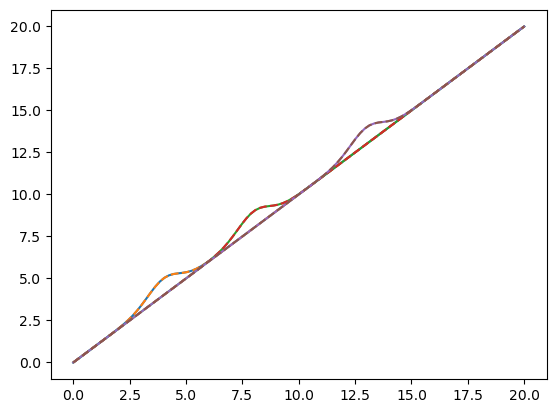

In [16]:
    

np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
start_code = time.time()
dt = 1
nx = ny = 100  #nx ny
solver  = 'exp'  # time integration method
tpe ="auto"
# Parámetros de simulación
T = 10         # Tiempo final
num_steps = int(round(T/dt,0))# Número de pasos de tiempo
real_dt= T/num_steps
#f=Expression('x[0]*(6*t - pow(x[0], 2) - 4*pow(x[0], 2)*t*t)*exp(-t*pow(x[0], 2))',t=0,degree=2)
f=Expression('1',t=0,degree=2) 
#f=Expression('4',t=0,degree=2) 
#q=Expression('-1',t=0,degree=2) #neumman BC
u_a = Expression('1/(sqrt(1+0.0004*t))*exp(-pow((x[0]-3-t),2)/(1+0.0004*t))+x[0]',t=0,degree=2)

u_0 = Expression('exp(-pow((x[0]-3),2))+x[0]',degree=2)
#u_0 = Expression('0.01*x[0]+1',degree=2)
#bc_1= 0 #left
#bc_2= Expression('0',t=0,degree=2)
BDF_coef = {"BDF1":[1,-1,0,0],"BDF2":[3./2,-2,1./2,0.0],"BDF3":[11/6,-3,3/2,-1/3],"BDF_OP":[0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3]}

# Creación de la malla y definición del espacio de funciones

start = 0
x_end = 20
mesh = IntervalMesh(nx, start, x_end)
contorno = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
left().mark(contorno, 1)
right().mark(contorno, 2)



t= 0
if solver == "exp":
    assemble_ti=time.time()
    V,u_t,v_t,A,C_1,Q_a,u_n,bcs = exp_form_no(mesh)
    assemble_t =time.time()- assemble_ti
elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
    V,L,R,bcs,u_n,u_nn,u_nnn = BDF_form(mesh,BDF_coef[solver])
else: 
    print("esquema de integración temporal erroneo")
    exit()
u_=Function(V)

L2=[]
table =[]
for n in range(num_steps):
    f.t=t
    #q.t=t
    t += real_dt
    u_a.t=t
    print(f'step:{n+1} of {num_steps} time = {t}')
    if solver == "exp":
        if tpe == 'auto': 
            Q=Q_t_no(Q_a,C_1,u_t,v_t,f,bcs)

            if n ==0:
                u_i=np.dot(A,u_n.vector().get_local())+Q
                u =exp_solver_no(A,u_i,n,table,True,0)
            else:
                u_i=np.dot(A,np.array(u)[0])+Q
                u =exp_solver_no(A,u_i,n,table,True,0,u)
        else: 
            m_u = int(sys.argv[4])
            Q=Q_t_no(Q_a,C_1,u_t,v_t,f,bcs)
            if n ==0:
                u_i=np.dot(A,u_n.vector().get_local())+Q
                u =exp_solver_no(A,u_i,n,table,False,m_u)
            else:
                u_i=np.dot(A,np.array(u)[0])+Q
                u =exp_solver_no(A,u_i,n,table,False,m_u,u)
        u_.vector()[:]=np.array(u)[0]
    elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
        solve(L == R, u_)
        u_nnn.assign(u_nn)
        u_nn.assign(u_n)
        u_n.assign(u_)

    x_cor=np.linspace(start,x_end,nx)

    # u_.rename("u_"+solver, "u_"+solver);vtkfile_uh.write(u_, t)
    # u_a_=project(u_a,V)
    # u_a_.rename("u", "u");vtkfile_u.write(u_a_, t) 

    u_p=[]
    u_an=[]
    for i in x_cor:
        u_p.append(u_(i))
        u_an.append(u_a(i))
    if near(t,real_dt,real_dt/2) or near(t,5,real_dt/2) or near(t,10,real_dt/2):
        plt.plot(x_cor,u_p)
        plt.plot(x_cor,u_an,'--')
    L2_norm=np.sum((np.array(u_an)-np.array(u_p))**2)**0.5 #assemble((u_ - u_an)**2 * dx)**0.5
    L2.append([L2_norm,t])
# plt.grid(True)
# plt.xlim = [0,100]
# plt.ylim = [0,6]
plt.show()    

end_code = time.time()
exec_t=end_code-start_code



In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 



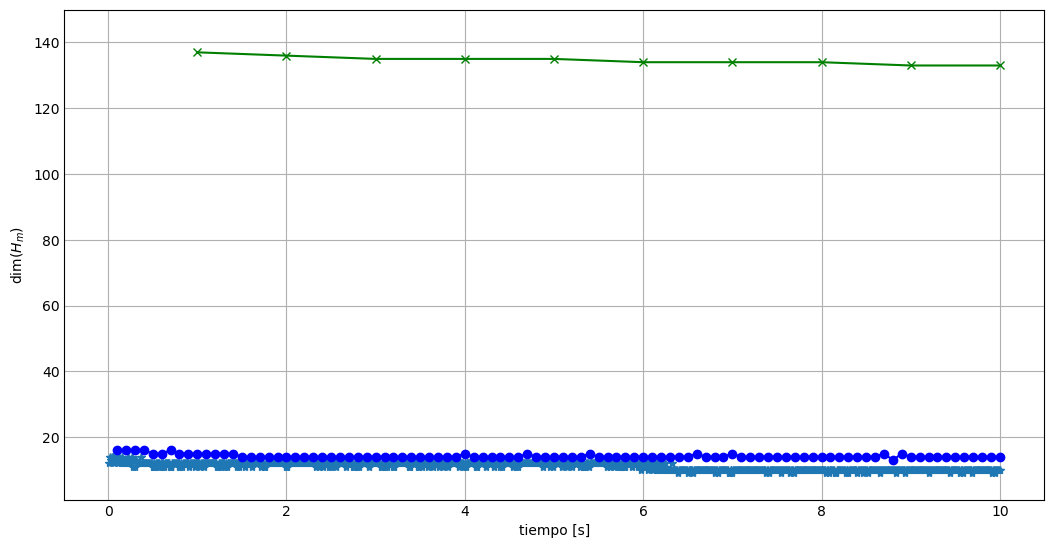

In [71]:
dt = pd.read_csv('no_homogeneo/results_dt_0.01/error_scheme_exp.csv')
dt1 = pd.read_csv('no_homogeneo/results_dt_0.1/error_scheme_exp.csv')
dt2 = pd.read_csv('no_homogeneo/results_dt_1.0/error_scheme_exp.csv')

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
ax.plot(dt['time'],dt['dim H_m'],  '*')
ax.plot(dt1['time'],dt1['dim H_m'],'o',c='blue')
ax.plot(dt1['time'],dt1['dim H_m'],'-',c='blue')
ax.plot(dt2['time'],dt2['dim H_m'], 'x',c='green')
ax.plot(dt2['time'],dt2['dim H_m'], '-',c='green')
ax.set(
       ylim=(1, 150))
plt.xlabel('tiempo [s]')
plt.ylabel('dim($H_m$)')
plt.show()

In [10]:
dtxa

,Unnamed: 0,exp,tiempo,krylov_time,solver_time,dim H_m,time
0,0,0.000013,0.01,0.090669,0.000146,12.0,0.01
1,1,0.000013,0.02,0.078814,0.001822,14.0,0.02
2,2,0.000013,0.03,0.082146,0.000154,13.0,0.03
3,3,0.000013,0.04,0.108752,0.000089,14.0,0.04
4,4,0.000014,0.05,0.255580,0.000276,14.0,0.05
...,...,...,...,...,...,...,...
995,995,0.000081,9.96,0.048544,0.000355,10.0,9.96
996,996,0.000081,9.97,0.044394,0.000912,10.0,9.97
997,997,0.000081,9.98,0.050289,0.000155,10.0,9.98
998,998,0.000081,9.99,0.042101,0.000188,10.0,9.99


In [23]:
dt2['1']=dt1['1']
dt2['2']=dt1['2']
dt2

,3,4,1,2
0,2,2,0,0
1,3,3,1,1


In [39]:
l=[[1,0],[1,1]]

In [40]:
np.array(l)[:,0]

array([1, 1])

In [37]:
dt1

,1,2,sa
0,0,0,0
1,1,1,1
